**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context('talk')

In [2]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'4.4.1'

In [3]:
# To update plotly, uncomment and run the following line:
# !pip install plotly --upgrade

## Ejercicio 1: 

1. Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

1. Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.
  1. Justificar cada columna no seleccionada.
  2. Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros.

2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.


In [4]:
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df.sample(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
13231,Mill Park,4 Vain Cl,3,h,665000.0,S,Ray,23/09/2017,17.9,3082.0,3.0,1.0,4.0,345.0,NaN,NaN,NaN,-37.67121,145.06246,Northern Metropolitan,10529.0
3452,Keilor East,45 Nyah St,4,h,920000.0,S,Rendina,10/09/2016,12.8,3033.0,3.0,2.0,2.0,603.0,NaN,1975.0,Moonee Valley,-37.73230,144.86830,Western Metropolitan,5629.0
11925,Cairnlea,16 Westbury St,3,h,640000.0,S,HAR,29/07/2017,14.8,3023.0,3.0,2.0,2.0,316.0,170.0,2008.0,Brimbank,-37.76048,144.78847,Western Metropolitan,2674.0


Columnas no autoexplicativas:
- Distance: Distancia al centro.
- Method: Cómo se vendió.
- Propertycount: Cantidad de casas en el suburbio.
- Bedroom2: Scraped # of Bedrooms (from different source)

## 1. Análisis previo

In [5]:
len(melb_df)

13580

In [6]:
melb_df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


In [7]:
melb_df.Address.nunique(), len(melb_df)


(13378, 13580)

Hay direcciones repetidas:
- Si el resto de las columnas difieren, quizá son unidades en el mismo edificio.
- Si cambia el precio, puede ser la misma unidad, con ventas sucesivas.


In [8]:
melb_df[melb_df.duplicated(subset='Address', keep=False)].sort_values('Address')

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
4958,Preston,1 Bellarine St,4,h,1400000.0,VB,Jellis,18/03/2017,8.8,3072.0,4.0,2.0,2.0,559.0,217.0,1925.0,Darebin,-37.73470,144.99660,Northern Metropolitan,14577.0
9281,Preston,1 Bellarine St,5,h,1400000.0,PI,hockingstuart,3/06/2017,8.4,3072.0,5.0,2.0,2.0,558.0,217.0,1925.0,Darebin,-37.73472,144.99658,Northern Metropolitan,14577.0
9144,Essendon,1 Daisy St,4,h,1360000.0,S,Jellis,3/06/2017,7.5,3040.0,4.0,2.0,1.0,267.0,NaN,NaN,Moonee Valley,-37.75472,144.92723,Western Metropolitan,9264.0
7802,Essendon,1 Daisy St,4,h,1400000.0,VB,Nelson,8/04/2017,8.0,3040.0,4.0,2.0,1.0,267.0,NaN,NaN,Moonee Valley,-37.75580,144.91060,Western Metropolitan,9264.0
10732,Maidstone,1/1 Clarendon St,3,t,650000.0,PI,Jas,8/07/2017,6.4,3012.0,3.0,2.0,2.0,159.0,128.0,2016.0,Maribyrnong,-37.78502,144.86733,Western Metropolitan,3873.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5186,Reservoir,9/99 Barton St,2,u,335000.0,S,Love,22/08/2016,11.2,3073.0,2.0,1.0,1.0,0.0,54.0,2012.0,Darebin,-37.71120,144.99890,Northern Metropolitan,21650.0
11069,Heidelberg Heights,97 Edwin St,4,h,1645000.0,PI,Fletchers,12/08/2017,8.8,3081.0,4.0,2.0,4.0,596.0,120.0,1930.0,Banyule,-37.75008,145.05051,Eastern Metropolitan,2947.0
3227,Heidelberg Heights,97 Edwin St,2,h,815000.0,SP,Fletchers,3/09/2016,10.5,3081.0,2.0,1.0,2.0,589.0,120.0,1930.0,Banyule,-37.75010,145.05050,Eastern Metropolitan,2947.0
6835,Carlton,99 Neill St,3,h,1600000.0,SP,Nelson,17/09/2016,1.8,3053.0,2.0,3.0,1.0,0.0,192.0,NaN,Melbourne,-37.79450,144.97180,Northern Metropolitan,6786.0


In [9]:
pd.unique(melb_df.Type)

array(['h', 'u', 't'], dtype=object)

In [10]:
pd.unique(melb_df.Method)

array(['S', 'SP', 'PI', 'VB', 'SA'], dtype=object)

In [11]:
pd.unique(melb_df.Bedroom2.sort_values())
# Hay un 20 que llama bastante la atención, sobre todo porque la cantidad máxima de ambientes es 10

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 20.])

In [12]:
pd.unique(melb_df.Car.sort_values())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

In [13]:
melb_df.Landsize.quantile(0.99)
# Aún dejando un quantile alto, el máximo baja considerablemente. También es raro que haya algunos con 0 en este valor (a menos que lo consideren como el espacio abierto)

2959.82999999998

In [14]:
melb_df.BuildingArea.quantile(0.99)
# Pasa lo mismo que con Landsize. Con alto quantile, el máximo de este dato baja mucho. También hay 0's, pero podrían ser terrenos sobre los que no se construyó

466.4200000000001

In [15]:
melb_df[melb_df.YearBuilt<1800]
# Hay un solo lugar construido aparentemente en 1196. O está mal el dato, o es un lugar histórico.

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
9968,Mount Waverley,5 Armstrong St,3,h,1200000.0,VB,McGrath,24/06/2017,14.2,3149.0,3.0,1.0,4.0,807.0,117.0,1196.0,Monash,-37.86788,145.12121,Eastern Metropolitan,13366.0


In [16]:
mel_council = pd.unique(melb_df.CouncilArea)
# Ojo que hay NaN's y Unavailable

In [17]:
mel_council

array(['Yarra', 'Moonee Valley', 'Port Phillip', 'Darebin', 'Hobsons Bay',
       'Stonnington', 'Boroondara', 'Monash', 'Glen Eira', 'Whitehorse',
       'Maribyrnong', 'Bayside', 'Moreland', 'Manningham', 'Banyule',
       'Melbourne', 'Kingston', 'Brimbank', 'Hume', nan, 'Knox',
       'Maroondah', 'Casey', 'Melton', 'Greater Dandenong', 'Nillumbik',
       'Whittlesea', 'Frankston', 'Macedon Ranges', 'Yarra Ranges',
       'Wyndham', 'Cardinia', 'Unavailable', 'Moorabool'], dtype=object)

In [18]:
pd.unique(melb_df.Regionname)

array(['Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Eastern Victoria',
       'Northern Victoria', 'Western Victoria'], dtype=object)

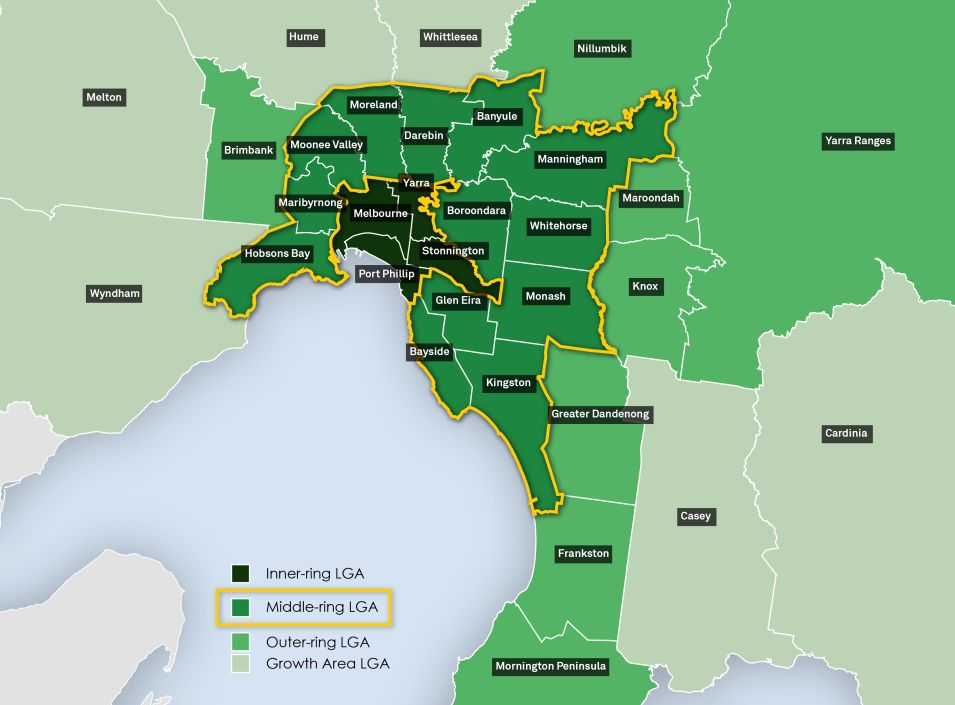

## 1.1.1 Outliers

In [19]:
melb_df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


Baños: Vamos a modificar las filas con 0 baños

In [20]:
# Baños
melb_df.Bathroom.replace({0.:1}, inplace=True)

In [21]:
melb_df[(melb_df.Landsize == 0) & (melb_df.BuildingArea.isna())]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
8,Abbotsford,6/241 Nicholson St,1,u,300000.0,S,Biggin,8/10/2016,2.5,3067.0,1.0,1.0,1.0,0.0,NaN,NaN,Yarra,-37.80080,144.99730,Northern Metropolitan,4019.0
10,Abbotsford,411/8 Grosvenor St,2,u,700000.0,VB,Jellis,12/11/2016,2.5,3067.0,2.0,2.0,1.0,0.0,NaN,NaN,Yarra,-37.81100,145.00670,Northern Metropolitan,4019.0
14,Abbotsford,7/20 Abbotsford St,1,u,441000.0,SP,Greg,14/05/2016,2.5,3067.0,1.0,1.0,1.0,0.0,NaN,NaN,Yarra,-37.80160,144.99880,Northern Metropolitan,4019.0
21,Abbotsford,13/11 Nicholson St,3,t,900000.0,S,Beller,18/03/2017,2.5,3067.0,3.0,2.0,2.0,0.0,NaN,2010.0,Yarra,-37.80930,144.99590,Northern Metropolitan,4019.0
26,Abbotsford,5/20 Abbotsford St,1,u,426000.0,SP,Greg,22/08/2016,2.5,3067.0,1.0,1.0,1.0,0.0,NaN,NaN,Yarra,-37.80160,144.99880,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12142,Richmond,3/30 Tanner St,2,u,575500.0,S,hockingstuart,29/07/2017,2.4,3121.0,2.0,1.0,1.0,0.0,NaN,NaN,Yarra,-37.82328,144.99203,Northern Metropolitan,14949.0
12155,Seaholme,1/27 Noordenne Av,1,u,312000.0,S,RT,29/07/2017,11.0,3018.0,1.0,1.0,0.0,0.0,NaN,NaN,Hobsons Bay,-37.86007,144.84578,Western Metropolitan,852.0
12165,South Yarra,10/38 Kensington Rd,1,u,555000.0,S,Jellis,29/07/2017,2.7,3141.0,1.0,1.0,1.0,0.0,NaN,NaN,Stonnington,-37.83631,145.00181,Southern Metropolitan,14887.0
12167,St Kilda,11/22 Charnwood Cr,1,u,481000.0,S,hockingstuart,29/07/2017,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,Port Phillip,-37.85984,144.98670,Southern Metropolitan,13240.0


YearbBuilt: La mayoría de las propiedades fueron construidas posterior a 1880. Hay una propiedad del 1196. La removemos.

In [22]:
melb_df.drop(melb_df.query('YearBuilt < 1800').index, inplace=True)

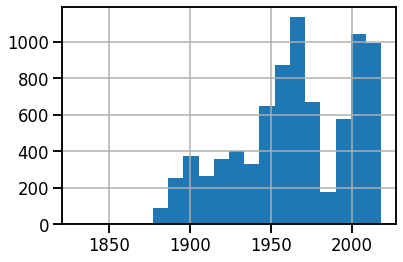

In [23]:
melb_df.YearBuilt.hist(bins=20)

In [24]:
melb_df.Car.value_counts()

2.0     5591
1.0     5509
0.0     1026
3.0      748
4.0      505
5.0       63
6.0       54
8.0        9
7.0        8
10.0       3
9.0        1
Name: Car, dtype: int64

Nos quedamos solament con las propiedades con espacio para 6 autos o menos.

In [25]:
melb_df = melb_df.query('Car < 7')

In [26]:
melb_df.Bedroom2.value_counts()

3.0     5859
2.0     3711
4.0     2586
1.0      688
5.0      555
6.0       62
0.0       16
7.0       10
8.0        5
9.0        2
10.0       1
20.0       1
Name: Bedroom2, dtype: int64

Nos quedamos solo con propiedades con cuartos en el rango [1,7]

In [27]:
melb_df = melb_df.query('(Bedroom2 > 0) & (Bedroom2 < 7)')

In [28]:
melb_df.Bathroom.value_counts()

1.0    7481
2.0    4939
3.0     907
4.0     101
5.0      28
6.0       4
7.0       1
Name: Bathroom, dtype: int64

In [29]:
melb_df = melb_df.query('(Bathroom > 0) & (Bathroom < 6)')

In [30]:
melb_df.Date = pd.to_datetime(melb_df.Date)

In [31]:
melb_df.Date.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                   13456
unique                     58
top       2017-05-27 00:00:00
freq                      472
first     2016-01-28 00:00:00
last      2017-12-08 00:00:00
Name: Date, dtype: object

Hay algunas propiedades cuya fecha de venta es previa a la construcción. Decidimos dejarlas ya que quizá se trata de ventas en pozo o similar.

In [32]:
melb_df[melb_df.Date.dt.year < melb_df.YearBuilt]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
441,Avondale Heights,157 Canning St,3,t,851000.0,S,Nelson,2016-03-12,10.5,3034.0,3.0,3.0,1.0,557.0,181.0,2017.0,Moonee Valley,-37.7700,144.8572,Western Metropolitan,4502.0
1234,Brighton East,8 Thomas St,2,h,1310000.0,S,Buxton,2016-09-24,10.7,3187.0,4.0,3.0,2.0,302.0,250.0,2018.0,Glen Eira,-37.9182,145.0231,Southern Metropolitan,6938.0
3489,Keilor East,20 Keith Gr,3,h,825000.0,S,Nelson,2016-04-23,12.8,3033.0,3.0,2.0,1.0,630.0,126.0,2017.0,Moonee Valley,-37.7378,144.8705,Western Metropolitan,5629.0
4282,Newport,7 Durkin St,3,h,945000.0,S,Jas,2016-05-28,8.4,3015.0,4.0,2.0,1.0,487.0,190.0,2017.0,Hobsons Bay,-37.8438,144.8806,Western Metropolitan,5498.0
5153,Reservoir,89 Darebin Bvd,4,h,767500.0,S,Barry,2016-09-17,11.2,3073.0,3.0,2.0,2.0,834.0,129.0,2017.0,Darebin,-37.7040,145.0299,Northern Metropolitan,21650.0
7060,Heidelberg,36 Buckingham Dr,3,h,1030000.0,S,Miles,2016-07-30,10.6,3084.0,5.0,3.0,2.0,649.0,357.0,2017.0,Banyule,-37.7501,145.0822,Eastern Metropolitan,2890.0


Hay algunas CouncilAreas que podemos remover porque no forman parte de Melbourne.  Adicionalmente reemplazamos _Unavailable_ por NaN para imputar luego.

In [33]:
ca_drop = melb_df[(melb_df.CouncilArea.str.contains('Macedon Ranges|Moorabool', case=False)) & (melb_df.CouncilArea.notna())].index
melb_df.drop(ca_drop, inplace=True)

In [34]:
melb_df.CouncilArea.replace({'Unavailable' : np.nan}, inplace=True)

## 1.2.1 Selección de columnas

In [35]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [36]:
melb_df.Method.value_counts()

S     8953
SP    1683
PI    1546
VB    1176
SA      90
Name: Method, dtype: int64

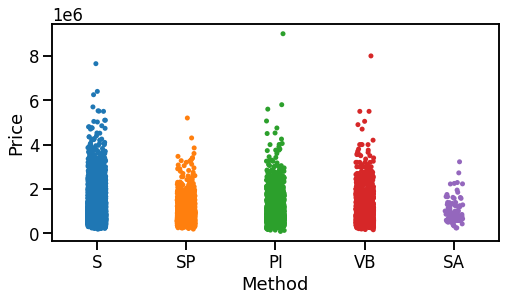

In [37]:
plt.subplots(figsize=(8,4))
sns.stripplot(x=melb_df.Method, y=melb_df.Price)

In [38]:
melb_df.SellerG.nunique()

265

In [39]:
melb_df.Lattitude.nunique()

6429

**Columnas que sacamos**:
- Suburb: Tiene 314 categorías, por lo que no sirve para agrupar a las propiedades (como sí podremos hacer utilizando CouncilArea ó Regionname).
- Address: Existen muchísimas direcciones, que no aportan información relevante para un posible modelo de predicción de precio.
- Method: Al analizar los precios en función del método de venta (ver gráfico), vemos que SA (vendido en una subasta) posee precios más bajos que el resto de los métodos, pero solamente hay 91 propiedades vendidas de ese modo. El resto de los métodos de venta, no muestran diferencias significativas en los precios.
- SellerG: Al no ser un atributo o característica de la propiedad, no debería ayudar a predecir el precio de las mismas.
- Lattitude y Longtitude: Al igual que la dirección, son valores demasiado específicos y únicos, por lo que no permiten generalizar y aportar información robusta a un posible modelo predictivo. Además existen otras columnas con información geográfica (CouncilArea, Regionname).

**Notas**:
- Postalcode: Esta columna normalmente también la removeríamos, pero dado que se utiliza posteriormente para unir otro dataset, la mantenemos.
- La columna _Method_ podríamos utilizarla para un modelo y que éste nos indique si es relevante o no, pero como aún no hemos visto técnicas de aprendizaje supervisado, momentáneamente la removemos.
- La longitud y latitud podría utilizarse para derivar nuevas columnas utilizando información externa (comercios, espacios verdes, universidades, medios de transporte público, etc) que seguramente aportarían al modelo. Dado que no es el objetivo en este trabajo, las hemos removido.

In [40]:
melb_df_sel_cols = melb_df.copy()
melb_df_sel_cols = melb_df[['Rooms', 'Type', 'Price', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Regionname', 'Propertycount', 'Suburb']]

## 1.2.2 Chequeo de columnas

In [41]:
melb_df_sel_cols

,Rooms,Type,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount,Suburb
0,2,h,1480000.0,2016-03-12,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,Northern Metropolitan,4019.0,Abbotsford
1,2,h,1035000.0,2016-04-02,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,Northern Metropolitan,4019.0,Abbotsford
2,3,h,1465000.0,2017-04-03,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,Northern Metropolitan,4019.0,Abbotsford
3,3,h,850000.0,2017-04-03,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,Northern Metropolitan,4019.0,Abbotsford
4,4,h,1600000.0,2016-04-06,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,Northern Metropolitan,4019.0,Abbotsford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,h,1245000.0,2017-08-26,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,NaN,South-Eastern Metropolitan,7392.0,Wheelers Hill
13576,3,h,1031000.0,2017-08-26,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,NaN,Western Metropolitan,6380.0,Williamstown
13577,3,h,1170000.0,2017-08-26,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,NaN,Western Metropolitan,6380.0,Williamstown
13578,4,h,2500000.0,2017-08-26,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,NaN,Western Metropolitan,6380.0,Williamstown


In [42]:
melb_df_sel_cols.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Propertycount
count,13448.000000,1.344800e+04,13448.000000,13448.000000,13448.000000,13448.000000,13448.000000,13448.000000,7068.000000,8138.000000,13448.000000
mean,2.932258,1.072476e+06,10.133388,3105.007213,2.909355,1.532719,1.598528,553.785470,151.749067,1964.995576,7456.014352
std,0.943771,6.357288e+05,5.802189,90.356951,0.932324,0.673722,0.926280,3993.376934,543.267492,36.146432,4380.406040
min,1.000000,8.500000e+04,0.000000,3000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1830.000000,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,4380.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,6567.000000
75%,3.000000,1.325000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,650.000000,174.000000,1999.000000,10331.000000
max,8.000000,9.000000e+06,48.100000,3977.000000,6.000000,5.000000,6.000000,433014.000000,44515.000000,2018.000000,21650.000000


In [43]:
for i in ['CouncilArea', 'Regionname','Type']:
  print(i)
  print(melb_df_sel_cols[i].value_counts())
  print('\n')

CouncilArea
Moreland             1159
Boroondara           1147
Moonee Valley         993
Darebin               927
Glen Eira             842
Stonnington           717
Maribyrnong           691
Yarra                 645
Port Phillip          628
Banyule               592
Bayside               487
Melbourne             469
Hobsons Bay           432
Brimbank              421
Monash                331
Manningham            310
Whitehorse            302
Kingston              206
Whittlesea            167
Hume                  164
Wyndham                86
Maroondah              80
Knox                   79
Melton                 66
Frankston              53
Greater Dandenong      51
Casey                  37
Nillumbik              36
Yarra Ranges           18
Cardinia                8
Name: CouncilArea, dtype: int64


Regionname
Southern Metropolitan         4642
Northern Metropolitan         3853
Western Metropolitan          2928
Eastern Metropolitan          1462
South-Eastern Metropoli

Vamos a agrupar _Eastern Victoria_, _Northern Victoria_, _Western Victoria_ en una sola region de **Victoria**

In [44]:
melb_df_sel_cols.Regionname.replace({'Eastern Victoria' : 'Victoria',
                                     'Northern Victoria' : 'Victoria',
                                     'Western Victoria' : 'Victoria'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Airbnb data

In [45]:
# data source:
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.



In [46]:
airbnb_df[:3]

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.772684,145.092133,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.766505,144.980736,35,200.0,803.0
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.859755,144.977369,159,1253.0,4452.0


In [47]:
airbnb_suburbs = airbnb_df.suburb.unique()
set(mel_council) & set(airbnb_suburbs)

{'Cardinia',
 'Frankston',
 'Manningham',
 'Maribyrnong',
 'Melbourne',
 'Whittlesea',
 nan}

Análisis para ver como mergear los datasets

In [48]:
airbnb_neigh = airbnb_df.neighborhood.unique()
set(mel_council) & set(airbnb_neigh)

{nan}

In [49]:
airbnb_city = airbnb_df.city.unique()


In [50]:
match_list = set(mel_council) & set(airbnb_city)
print(len(airbnb_city))
print (len(match_list))

30
30


In [51]:
airbnb_df.columns

Index(['description', 'neighborhood_overview', 'street', 'neighborhood',
       'city', 'suburb', 'state', 'zipcode', 'latitude', 'longitude', 'price',
       'weekly_price', 'monthly_price'],
      dtype='object')

Columnas seleccionadas:
- _price_: Existen tres columnas de precios, pero la de precio diario posee la menor cantidad de nulos. Vamos a calcular alguna medida estadística agrupando por city, para luego utilizarlo como feature adicional .
- _city_: Es el equivalente a CouncilArea del dataset de melbourne. 
- _zipcode_: Esta columna será utilizada como _key_ para el join con el dataset de Melbourne.

In [52]:
airbnb_df = airbnb_df[['price', 'city', 'zipcode']]

## 1.3.2 Merge

In [53]:
airbnb_df.zipcode.replace({'VIC 3161': 3161,
'VIC': np.nan, '3000\n3000': 3000, '3084\n\n3084': 3084}, inplace=True)

In [54]:
airbnb_df.zipcode = airbnb_df.zipcode.astype('float')

In [55]:
airbnb_df_gb = airbnb_df.groupby('zipcode', as_index=False).agg(cantidad=('city','count'), council=('city','unique'), price_mean=('price', 'mean') ).sort_values('cantidad', ascending=False)

In [56]:
airbnb_df_gb

,zipcode,cantidad,council,price_mean
3,3000.0,3368,"[Melbourne, Yarra, Port Phillip, Moreland, Cas...",150.470012
8,3006.0,1268,"[Melbourne, Port Phillip, Yarra]",188.851735
154,3182.0,1135,"[Port Phillip, Stonnington]",147.729515
116,3141.0,881,"[Melbourne, Stonnington]",157.912599
7,3004.0,728,"[Melbourne, Port Phillip, Maribyrnong, Stonnin...",158.271978
...,...,...,...,...
172,3200.0,1,[Frankston],40.000000
1,2134.0,1,[Yarra],50.000000
79,3096.0,1,[Nillumbik],100.000000
2,2582.0,1,[Hume],104.000000


In [57]:
zipcode_ca_missing = melb_df_sel_cols[melb_df_sel_cols.CouncilArea.isna()].Postcode.unique()

In [58]:
airbnb_df_gb['count_councils'] = airbnb_df_gb.council.apply(len)

In [59]:
airbnb_df_gb

,zipcode,cantidad,council,price_mean,count_councils
3,3000.0,3368,"[Melbourne, Yarra, Port Phillip, Moreland, Cas...",150.470012,6
8,3006.0,1268,"[Melbourne, Port Phillip, Yarra]",188.851735,3
154,3182.0,1135,"[Port Phillip, Stonnington]",147.729515,2
116,3141.0,881,"[Melbourne, Stonnington]",157.912599,2
7,3004.0,728,"[Melbourne, Port Phillip, Maribyrnong, Stonnin...",158.271978,7
...,...,...,...,...,...
172,3200.0,1,[Frankston],40.000000,1
1,2134.0,1,[Yarra],50.000000,1
79,3096.0,1,[Nillumbik],100.000000,1
2,2582.0,1,[Hume],104.000000,1


Existen zipcodes que tienen múltiples councils, por lo que como primer paso, decidimos quedarnos con los zipcodes con uno solo. Luego utilizamos esos zipcodes para hacer el merge con el dataset de Melbourne para completar los NaN de CouncilArea.

In [60]:
airbnb_merge =  airbnb_df_gb[airbnb_df_gb.count_councils == 1][['zipcode', 'council']]
airbnb_merge['council'] = airbnb_merge['council'].apply(lambda x:x[0])

airbnb_merge_price =  airbnb_df_gb[['zipcode', 'price_mean']]

In [61]:
melb_df_sel_cols = melb_df_sel_cols.merge(airbnb_merge, how='left', left_on='Postcode', right_on='zipcode')
melb_df_sel_cols = melb_df_sel_cols.merge(airbnb_merge_price, how='left', left_on='Postcode', right_on='zipcode')

melb_df_sel_cols.drop(columns=["zipcode_x", "zipcode_y"], inplace = True)

In [62]:
melb_df_sel_cols.sample(10)

,Rooms,Type,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount,Suburb,council,price_mean
114,2,h,1750000.0,2016-11-27,3.3,3206.0,2.0,1.0,1.0,162.0,NaN,NaN,Port Phillip,Southern Metropolitan,3280.0,Albert Park,Port Phillip,229.418033
4753,2,u,1252000.0,2016-09-24,3.8,3207.0,2.0,1.0,2.0,0.0,NaN,NaN,Port Phillip,Southern Metropolitan,8648.0,Port Melbourne,NaN,200.210117
7370,4,h,1740000.0,2016-05-22,5.3,3032.0,3.0,3.0,2.0,650.0,242.0,1925.0,Moonee Valley,Western Metropolitan,1052.0,Travancore,NaN,111.613636
5141,4,h,750000.0,2016-06-18,11.2,3073.0,4.0,1.0,2.0,747.0,NaN,NaN,Darebin,Northern Metropolitan,21650.0,Reservoir,NaN,273.926471
7427,3,u,2120000.0,2017-04-29,6.3,3143.0,3.0,2.0,3.0,395.0,NaN,NaN,Stonnington,Southern Metropolitan,4836.0,Armadale,Stonnington,192.463768
4979,4,h,920000.0,2016-06-27,8.8,3072.0,3.0,1.0,1.0,396.0,184.0,1920.0,Darebin,Northern Metropolitan,14577.0,Preston,Darebin,94.156028
5260,2,h,1506000.0,2016-07-05,2.6,3121.0,2.0,2.0,1.0,220.0,131.0,1920.0,Yarra,Northern Metropolitan,14949.0,Richmond,NaN,162.262739
5965,3,h,607000.0,2017-02-25,12.6,3020.0,3.0,1.0,2.0,563.0,122.0,1965.0,Brimbank,Western Metropolitan,3755.0,Sunshine,Brimbank,69.555556
5702,1,u,455000.0,2017-11-02,1.2,3006.0,1.0,1.0,0.0,760.0,70.0,2007.0,Melbourne,Southern Metropolitan,8400.0,Southbank,NaN,188.851735
8231,3,h,1020000.0,2017-05-13,8.8,3072.0,3.0,2.0,2.0,670.0,140.0,NaN,Darebin,Northern Metropolitan,14577.0,Preston,Darebin,94.156028


## 1.3.3 Investigación de variables para combinar

In [63]:
airbnb_df_full = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (35,77) have mixed types.Specify dtype option on import or set low_memory=False.



In [64]:
airbnb_df_full.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'neighborhood_overview', 'notes', 'transit',
       'access', 'interaction', 'house_rules', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighborhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 

Una forma de combinar los datasets sería traer información de la latitud y la longitud para realizar el merge, esta forma sería adecuada ya que podríamos considerar una distancia coherente para evitar una gran varianza de los datos. A su vez esta forma de conectar los datos, bien implementada, podría traer mayor precisión.

Otra forma sería a traves de la variable "Street" ya que ambos datasets poseen estas variables. Creemos que esta forma no es tan precisa y puede haber calles que compartan CouncilArea o Neighbourhoods.


 ## Ejercicio 2: Imputación

1. Imputar los valores faltantes de la columna CouncilArea en base a la información presente en Suburb. (Si en el punto anterior no seleccionó ninguna de estas variables, agréguelas ahora el conjunto de datos).

2. Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.




## 2.1 Imputar los valores faltantes de la columna CouncilArea 

In [65]:
len(melb_df_sel_cols[melb_df_sel_cols.CouncilArea.isna()])

1304

In [66]:
len(melb_df_sel_cols[(melb_df_sel_cols.CouncilArea.isna()) & (melb_df_sel_cols.council.isna())])

695

Imputamos la información faltante de CounArea con los datos de Airbnb, buscando acorde al zipcode. Para los 695 datos restantes, completamos con los datos de Suburb tal como se requería en la consigna.

In [67]:
melb_df_sel_cols['CouncilArea'] = melb_df_sel_cols.CouncilArea.fillna(melb_df_sel_cols.council)
melb_df_sel_cols['CouncilArea'] = melb_df_sel_cols.CouncilArea.fillna(melb_df_sel_cols.Suburb)

In [68]:
len(melb_df_sel_cols[melb_df_sel_cols.CouncilArea.isna()])

0

In [69]:
print(f'Cantidad de NaN en la columna CouncilAirea: {melb_df_sel_cols.CouncilArea.isna().sum()}')

Cantidad de NaN en la columna CouncilAirea: 0


## 2.2 Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.

In [70]:
len(melb_df_sel_cols[melb_df_sel_cols.price_mean.isna()])

12

In [71]:
precio_promedio_ciudad = airbnb_df.groupby("city").price.mean().reset_index()
precio_promedio_ciudad.rename(columns={"price": "precio_alquiler_promedio"}, inplace = True)

In [72]:
precio_promedio_ciudad

,city,precio_alquiler_promedio
0,Banyule,109.453202
1,Bayside,225.421333
2,Boroondara,157.072289
3,Brimbank,79.092593
4,Cardinia,167.121951
5,Casey,215.843137
6,Darebin,126.458453
7,Frankston,158.632768
8,Glen Eira,118.541997
9,Greater Dandenong,99.680272


In [73]:
melb_df_sel_cols = melb_df_sel_cols.merge(precio_promedio_ciudad, how='left', left_on='CouncilArea', right_on='city')
melb_df_sel_cols['price_mean'] = melb_df_sel_cols.price_mean.fillna(melb_df_sel_cols.precio_alquiler_promedio)


In [74]:
len(melb_df_sel_cols[melb_df_sel_cols.price_mean.isna()])

7

Dado que solo quedan 7 valores sin precio promedio de 13000 aproximadamente, y que no es un numero representativo con respecto al total de filas del dataset, elegimos eliminar estos 7 registros que contienen NaN.

In [75]:
melb_df_sel_cols.dropna(inplace=True, subset=['price_mean'])

## Ejercicio 3

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## 3 Emprolijamos en dataset para exportarlo y guardarlo

In [76]:
melb_df_sel_cols.drop(columns=['council', 'city', 'precio_alquiler_promedio'], inplace=True, axis=1)

In [77]:
melb_df_sel_cols.rename(columns={'price_mean': 'PrecioPromedioAirbnb'}, inplace=True)


In [78]:
melb_df_sel_cols.to_csv('MelbourneCurado.csv')